In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
Found 8000 files belonging to 8 classes.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
Target Keywords: ['up', 'down', 'left', 'right']
Unknown Keywords: ['go', 'no', 'stop', 'yes']
New Class to Index Mapping: {'up': 0, 'down': 1, 'left': 2, 'right': 3, 'unknown': 4, 'silence': 5}

Samples shape: (64, 16000)
Labels shape: (64,)
Unique labels in batch: [0 1 2 3 4 5]


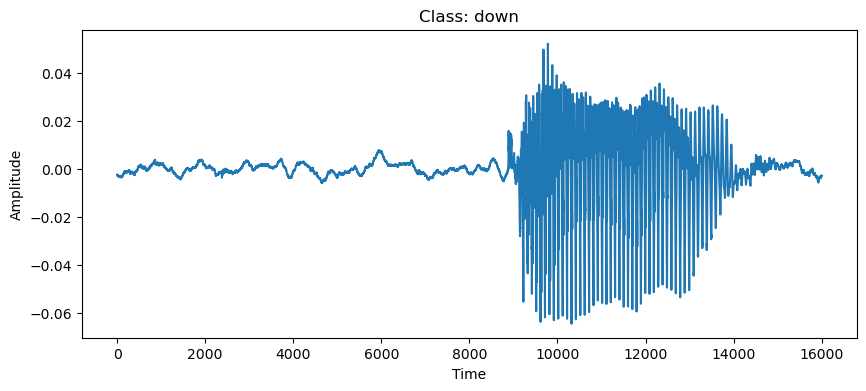

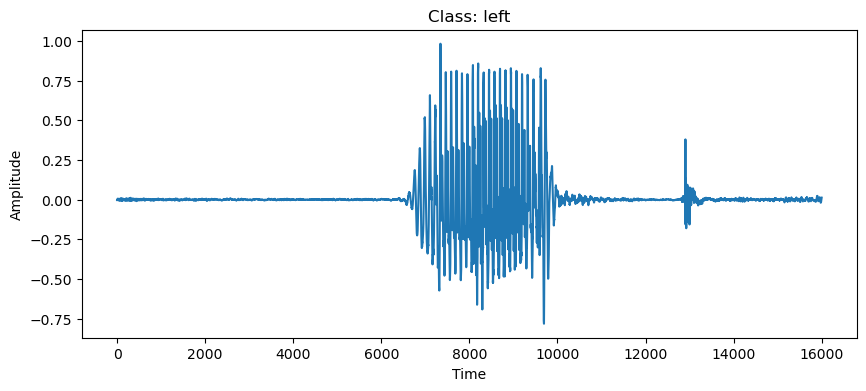

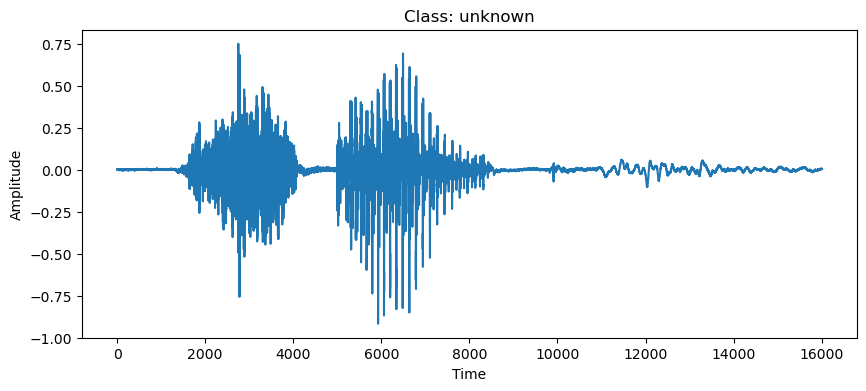

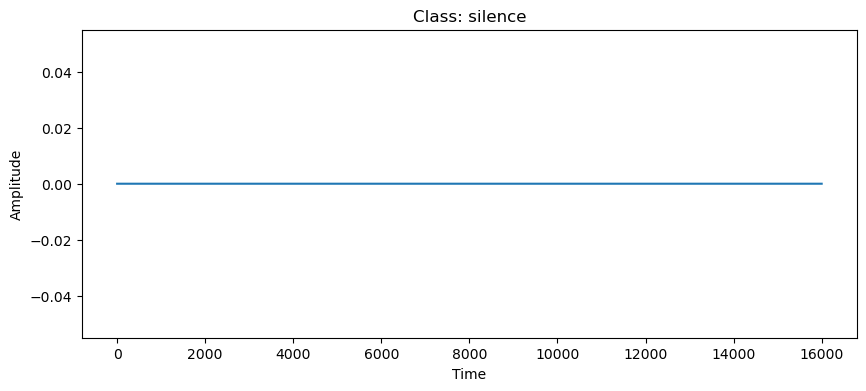

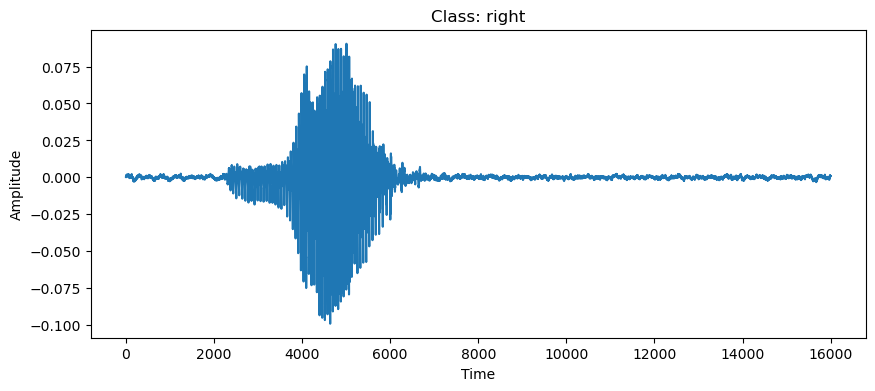

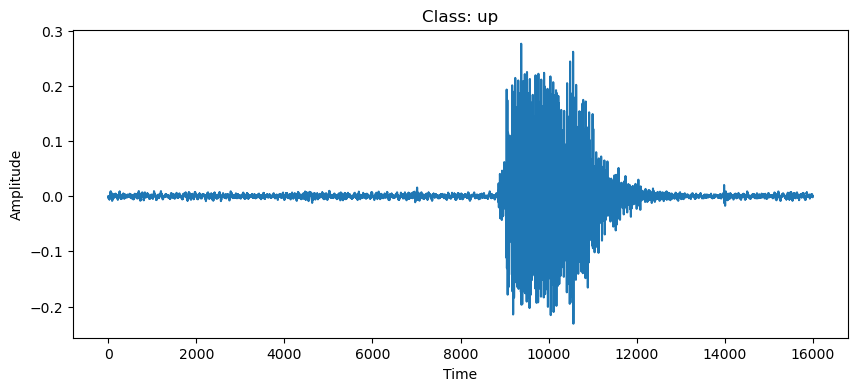

Total number of samples: 10000
Number of training batches: 125
Number of validation batches: 16
Number of test batches: 16
Number of training samples: 8000
Number of validation samples: 1000
Number of test samples: 1000
Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


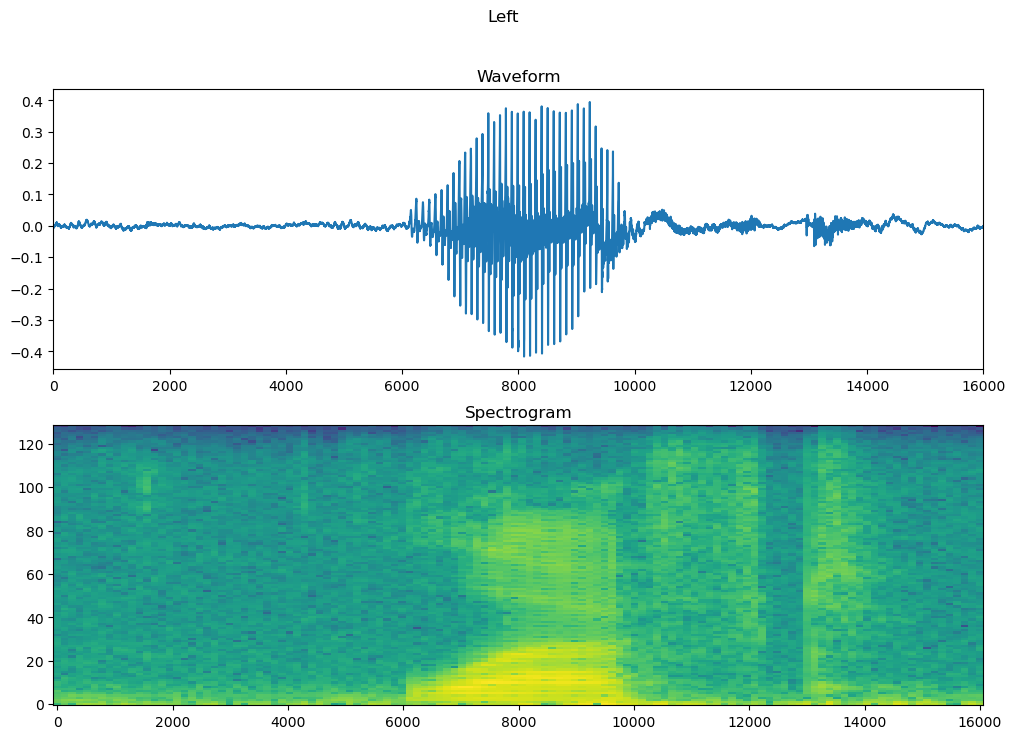

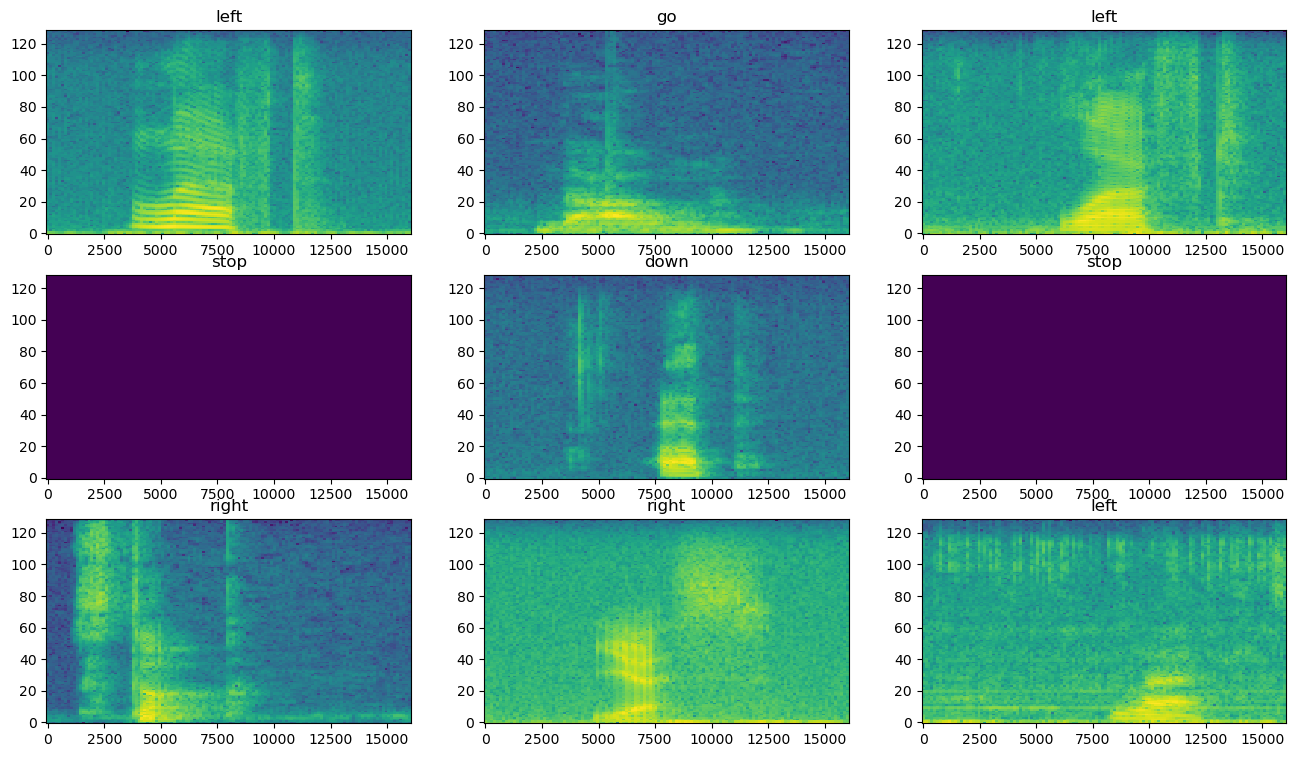

In [2]:
from audio_model_training import train_spectrogram_ds, test_spectrogram_ds, val_spectrogram_ds

In [3]:
# Cache and prefetch datasets for faser reading when training
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [4]:
# Get input shape and number of classes
for spectrograms, labels in train_spectrogram_ds.take(1):
    input_shape = spectrograms.shape[1:]
    num_classes = len(np.unique(labels.numpy()))
    print('Input shape:', input_shape)
    print('Number of classes:', num_classes)

Input shape: (124, 129, 1)
Number of classes: 6


# Define models

[model inspiration paper](https://www.isca-archive.org/interspeech_2015/sainath15b_interspeech.html)

[model inspiration code from TF](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/speech_commands/models.py#L673)

^^^ two OG papers that are definitelly good

[general keywrod spotting on microcontroller paper](https://arxiv.org/abs/1711.07128)


[binary quantization paper, might not be possible with tf and espressif](https://www.isca-archive.org/interspeech_2022/wang22g_interspeech.html)

These two papers go into other possible model architecutes:

[model with temporal convolutions](https://www.isca-archive.org/interspeech_2020/li20s_interspeech.html)

[depthwise conv](https://www.isca-archive.org/interspeech_2020/xu20d_interspeech.html) this might be very good

maybe for NAS:

[micronets maybe for NAS](https://arxiv.org/abs/2010.11267)

In [5]:
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Activation, Input, Reshape, Multiply, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, ReLU, Dropout


In [6]:
def plot_training_history(history, model_number):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Model {model_number} - Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Model {model_number} - Training and Validation Loss')
    plt.show()


In [7]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

### Resnet types model

In [8]:


def squeeze_excite_block(input_tensor, ratio=4):
    filters = input_tensor.shape[-1]
    se_shape = (1, 1, filters)

    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)

    # Excitation: Bottleneck with two Dense layers
    se = Dense(max(filters // ratio, 1), activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)

    # Scale: Multiply the input tensor by the recalibrated weights
    x = Multiply()([input_tensor, se])
    return x

# Depthwise Separable Convolution Block
def depthwise_separable_conv_block(x, filters, kernel_size=(4, 4), strides=(1, 1), padding='same'):
    x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding=padding, use_bias=True)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=(1, 1), padding='same', use_bias=True)(x)
    x = Activation('relu')(x)
    return x

In [57]:
# Optimized DS-ResNet10 Model with Squeeze-and-Excitation Block
def ds_resnet10_se(input_shape=(124, 129, 1), num_classes=6):
    inputs = Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv2D(64, (4, 4), padding='same', use_bias=True)(inputs)
    x = Activation('relu')(x)

    # Squeeze-and-Excitation block
    # x = squeeze_excite_block(x, ratio=2)

    # Depthwise Separable Convolutional Layers
    for _ in range(1):
        x = depthwise_separable_conv_block(x, filters=16)
        # Squeeze-and-Excitation block after each DS Conv Block
        # x = squeeze_excite_block(x, ratio=2)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Output Layer
    outputs = Dense(num_classes)(x)

    # Model Definition
    model = Model(inputs, outputs)
    return model

### Basic Model 

This model is large but achieves decent accuracy

In [58]:
def create_model_1(input_shape, num_classes):
    model = tf.keras.models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes),
])
    return model

## Model 2 smaller version of model 1

In [59]:
def create_model_2(input_shape, num_classes):
    model = tf.keras.models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    #layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes),
    ])
    return model

## Model 3 Tiny Conv model from paper

In [60]:
def create_tiny_conv_model_small(input_shape=(124, 129, 1), num_classes=6, is_training=True):
    """
    Builds a tiny convolutional model optimized for microcontrollers.

    Args:
        input_shape: Tuple, the shape of the input data (time_steps, frequency_bins, channels).
        num_classes: Integer, number of output classes.
        is_training: Boolean, whether the model is being trained or deployed.

    Returns:
        model: Keras Model instance.
    """
    inputs = Input(shape=input_shape, name='input')

    # Convolutional Layer
    x = Conv2D(filters=8,
               kernel_size=(10, 8),
               strides=(2, 2),
               padding='same',
               use_bias=True,
               kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
               bias_initializer='zeros',
               name='conv')(inputs)
    
    # ReLU Activation
    x = ReLU(name='relu1')(x)
    
    # Optional Dropout Layer
    if is_training:
        x = Dropout(rate=0.2, name='dropout1')(x)
    
    # Flatten the output
    x = Flatten(name='flatten')(x)
    
    # Output Layer
    outputs = Dense(units=num_classes,
                    activation='softmax',  # Use 'softmax' if you prefer probabilities
                    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
                    bias_initializer='zeros',
                    name='fc2')(x)
    
    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name='tiny_conv_model')
    
    return model


In [65]:
def create_tiny_embed_conv_model_small(input_shape=(124, 129, 1), num_classes=6, is_training=True):
    """
    Builds a tiny convolutional model optimized for microcontrollers.

    Args:
        input_shape: Tuple, the shape of the input data (time_steps, frequency_bins, channels).
        num_classes: Integer, number of output classes.
        is_training: Boolean, whether the model is being trained or deployed.

    Returns:
        model: Keras Model instance.
    """
    inputs = Input(shape=input_shape, name='input')

    # Convolutional Layer
    x = Conv2D(filters=8,
               kernel_size=(10, 8),
               strides=(2, 2),
               padding='same',
               use_bias=True,
               kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
               bias_initializer='zeros',
               name='conv1')(inputs)
    
    # ReLU Activation
    x = ReLU(name='relu1')(x)
    
    # Optional Dropout Layer
    if is_training:
        x = Dropout(rate=0.2, name='dropout1')(x)

    # Convolutional Layer
    x = Conv2D(filters=8,
               kernel_size=(10, 8),
               strides=(8, 8),
               padding='same',
               use_bias=True,
               kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
               bias_initializer='zeros',
               name='conv2')(x)
    
    # ReLU Activation
    x = ReLU(name='relu2')(x)
    
    # Optional Dropout Layer
    if is_training:
        x = Dropout(rate=0.2, name='dropout2')(x)
    
    # Flatten the output
    x = Flatten(name='flatten')(x)
    
    # Output Layer
    outputs = Dense(units=num_classes,
                    activation='softmax',  # Use 'softmax' if you prefer probabilities
                    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
                    bias_initializer='zeros',
                    name='fc2')(x)
    
    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name='tiny_embed_conv_model')
    
    return model



Training Model 1


Model: "tiny_conv_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 124, 129, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv (Conv2D)                   │ (None, 62, 65, 8)      │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 62, 65, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 62, 65, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 6)              │       193,446 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,094 (758.18 KB)

 Trainable params: 194,094 (758.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5236 - loss: 1.3341 - val_accuracy: 0.6510 - val_loss: 0.9622
Epoch 2/20
  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6900 - loss: 0.8251 

c:\Users\adamk\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6756 - loss: 0.8614 - val_accuracy: 0.6780 - val_loss: 0.8840
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7220 - loss: 0.7420 - val_accuracy: 0.7360 - val_loss: 0.7908
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7843 - loss: 0.5856 - val_accuracy: 0.7770 - val_loss: 0.7296
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8298 - loss: 0.4856 - val_accuracy: 0.7760 - val_loss: 0.7037
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8542 - loss: 0.4157 - val_accuracy: 0.7900 - val_loss: 0.6767
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8714 - loss: 0.3601 - val_accuracy: 0.8180 - val_loss: 0.6382
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8869 - loss: 0.3246 - val_accuracy: 0.8180 - val_loss: 0.7271
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8978 - loss: 0.2951 - val_accuracy: 0.8400 - v

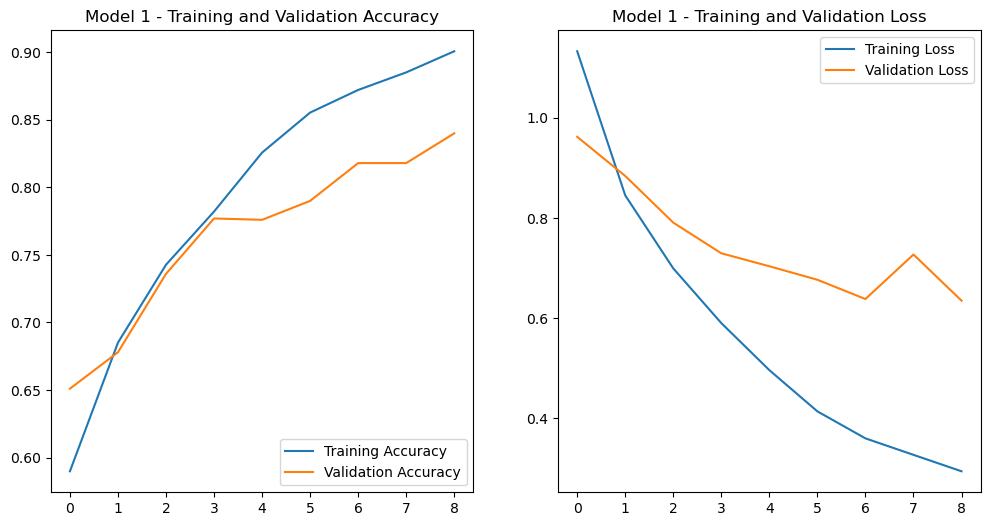


Training Model 2


Model: "tiny_embed_conv_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 124, 129, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 62, 65, 8)      │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 62, 65, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 62, 65, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 8, 9, 8)        │         5,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (ReLU)                    │ (None, 8, 9, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 8, 9, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 6)              │         3,462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,238 (36.09 KB)

 Trainable params: 9,238 (36.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4330 - loss: 1.5009 - val_accuracy: 0.6170 - val_loss: 1.0712
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6157 - loss: 1.0208 - val_accuracy: 0.6300 - val_loss: 0.9259
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6437 - loss: 0.9111 - val_accuracy: 0.6630 - val_loss: 0.8958
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6742 - loss: 0.8673 - val_accuracy: 0.6910 - val_loss: 0.8596
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6803 - loss: 0.8340 - val_accuracy: 0.7180 - val_loss: 0.8068
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6984 - loss: 0.7937 - val_accuracy: 0.7290 - val_loss: 0.7428
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7225 - loss: 0.7432 - val_accuracy: 0.7320 - val_loss: 0.7426
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7380 - loss: 0.6971 - val_accu

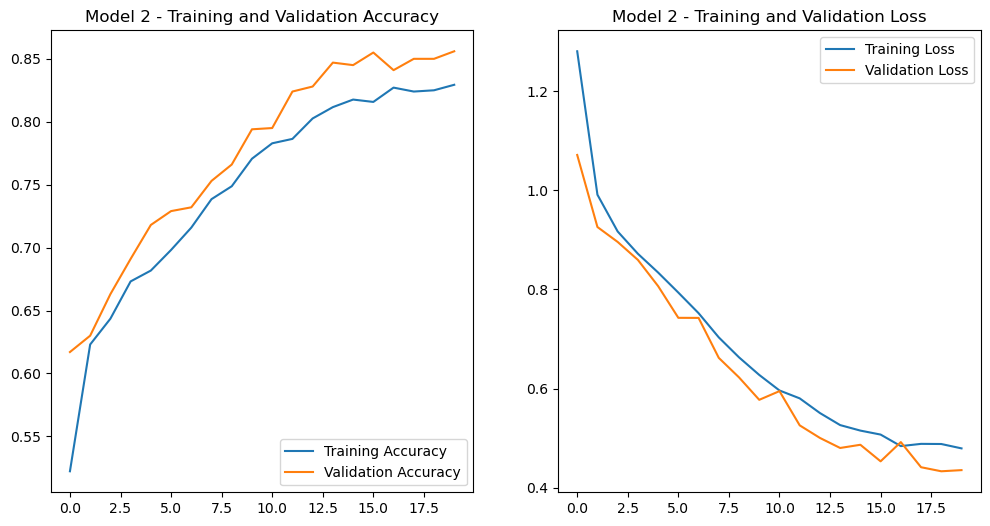

In [66]:
models = []
histories = []

for i, create_model in enumerate([create_tiny_conv_model_small, create_tiny_embed_conv_model_small], start=1):
    print(f'\nTraining Model {i}')
    model = create_model(input_shape, num_classes)
    model.summary()
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    history = model.fit(
        train_spectrogram_ds,
        validation_data=val_spectrogram_ds,
        epochs=20,  # You can adjust the number of epochs
        callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2, min_delta=0.01),
        verbose = 1
    )
    models.append(model)
    histories.append(history)
    plot_training_history(history, i)


In [21]:
def create_model_3(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [22]:
def create_model_4(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [23]:
def create_model_5(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.SeparableConv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.SeparableConv2D(32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Compile and Train models

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7857 - loss: 0.6955
Total non-trainable parameters: 0.0
Total trainable parameters: 49758
Model 1 Test Accuracy: 0.7820


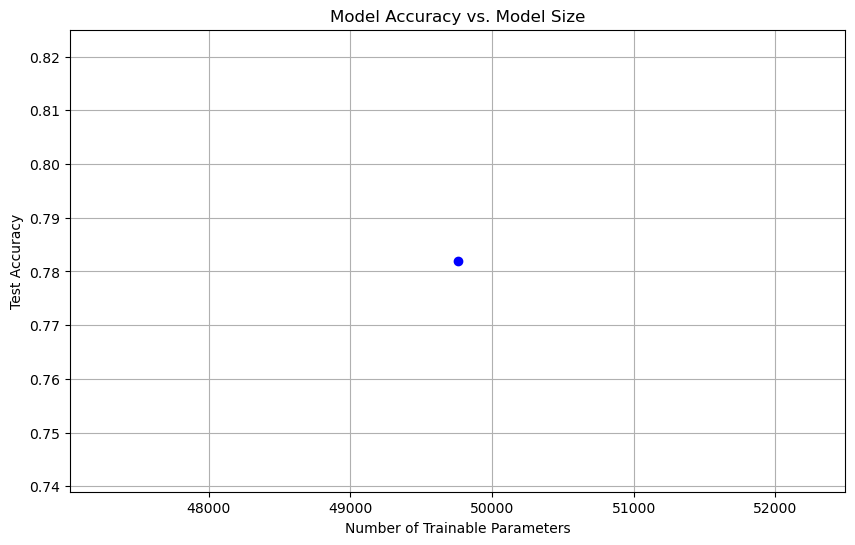

In [24]:
# List to store the results
accuracies = []
model_sizes = []

# Evaluate each model and store the results
for i, model in enumerate(models, start=1):
    test_loss, test_acc = model.evaluate(test_spectrogram_ds)
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
    
    # Print the details
    print(f"Total non-trainable parameters: {non_trainable_params}")
    print(f"Total trainable parameters: {trainable_params}")
    print(f'Model {i} Test Accuracy: {test_acc:.4f}')
    
    # Store the accuracy and model size
    accuracies.append(test_acc)
    model_sizes.append(trainable_params)

# Plotting accuracy vs. model size
plt.figure(figsize=(10, 6))
plt.plot(model_sizes, accuracies, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Number of Trainable Parameters')
plt.ylabel('Test Accuracy')
plt.title('Model Accuracy vs. Model Size')

# Display the plot
plt.grid(True)
plt.show()


# Quantize models